<a href="https://colab.research.google.com/github/wdconinc/practical-computing-for-scientists/blob/master/Lectures/lecture31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 31: Machine Learning

## Last Episode

Introduction to machine learning:
- classification (discrete targets) versus regression (continuous targets)
- supervised (training data) versus unsupervised (clustering)
- training versus validation versus test subsets
- linear regresion on a set of diabetes test data:
  - quadratic loss function similar to least squares regression
  - batched stochastic gradient descent (though our data set was small)
  - predicting the diabetes 'score' (continuous integer target variable)
  - from ten features: some categorical, some continuous, all rescaled to $z = (x - \mu) / \sigma$

## Loss Functions in Linear Regression

In linear regression we optimized the parameters of our model using a loss function. In particular we used the mean square of the errors (MSE):
$$ MSE = L_2 = \sum_i | y - \hat{y} |^2 $$

We could have chosen a different loss function, e.g. the mean absolute errors (MAE):
$$ MAE = L_1 = \sum_i | y - \hat{y} | $$
or even a custom $L_q$ such that
$$ L_q = \sum_i | y - \hat{y} |^q $$

We could also add additional terms to the loss function to 'suggest' to the training algorithm that we desire certain qualities in our solution. If we have a vector of weights $\vec{w}$ which we are determining, then we can add a regularization terms:
$$ L = L_2 + \frac{1}{2} w^T w $$

### Transition to Classification

The loss functions above, however, do not work for classification problems. How can we interpret MSE? Instead we use alternative loss functions which we attempt to minimize:
- error rate (ER), simply the fraction of incorrectly classified predictions: $f(C_2|C_1) + f(C_1|C_2)$ when we have a truth table
$$ \Big[ \begin{array}{cc} f(C_1|C_1) & f(C_2|C_1) \\ f(C_1|C_2) & f(C_2|C_2) \end{array} \Big] $$
- weighted error rates, when we care more strongly about certain misclassifications: $L_{21} f(C_2|C_1) + L_{12} f(C_1|C_2)$ (for example we want to more strongly avoid not diagnozing the disease when the patient is ill, than diagnozing a healthy patient).

We will also look at a very common but quite different loss function based on entropy. But first we must introduce the concept of entropy in information theory.

## Entropy: From Physics to Information Theory

From the introductory physics courses (or from a more advanced thermodynamics course) you may be familiar with the concept of *entropy*, the disorder in a system:
$$ S = k \ln W $$
where $k$ is the Boltzman constant and $W$ the *multiplicity* of the state. In particular the entropy can be written as
$$\frac{N!}{\prod n_i!}$$
when we consider the common situation of dividing $N$ particles such that $n_i$ are in state $i$. Using Stirling's formula $N! = N \ln N - N$, the entropy then becomes
$$ S = - k \sum_i \frac{n_i}{N} \ln \frac{n_i}{N} $$
and we could interpret the fractions a probabilities (in a frequentist interpretation of statistics).

In information theory we can also define an entropy. It will turn out that this entropy is a convenient loss function for logistic regression since it is written for probabilities.

### Information Theory and Entropy

Before thinking about a supervised learning problem in which we wish to construct a classification algorithm, let us consider the information content in a stream of categorical random variables.

Let's consider, for example, the stream of randomly chosen binary numbers $x = 0$ or $x = 1$, where $p(x)$ gives the probability distribution for either number to appear. An example could be 
$$ 110101001000111101001011101010111101011010 $$

In the case of $p(0) = 1$ and $p(1) = 0$, or if $p(0) = 0$ and $p(1) = 1$, the choice of the 'random' numbers is entirely predictable. The stream will be either all zeros or all ones. There is no new information present in each consecutive value.

If, on the other hand, $p(x)$ is not in this special case, then each successive value adds information to our determination of $p(x)$ itself. In particular, if we suddenly see a value $x$ which is very improbable, i.e. $p(x)$ is very small, then this will likely be an event with more information.

We introduce a quantity $h(x)$ that encodes the information in the observation of a value $x$ in the stream. We can associated three properties with this information content of a new observation:
- $h(x)$ must be larger for events with smaller $p(x)$,
- the information in indepedent consecutive values must be additive: $h(x_1, x_2) = h(x_1) + h(x_2)$,
- independent consecutive values will have a probability given by the product: $p(x_1, x_2) = p(x_1) p(x_2)$.

Based on these properties we can introduce
$$ h(x) = - \log p(x) $$
as the quantity of information in an observation of $x$.

We can now calculate the expectation value of the total information content in the entire stream, by multiplying all possible $x$ with their respective probability of occuring:
$$ H[x] = - \sum_x p(x) \log p(x) $$
This is the *information entropy* in the stream.

In the previous we have not specified which $\log$ to take. It is common to use $^2\log$ in information theory. We will use the natural log $\ln$, but there are no big differences. Let's work in $^2\log$ for now but use $\ln$ for all future work.

Examples:
- if $x = 0,1$ and $p(0) = 0$ and $p(1) = 1$ then $H[x] = 0$ (since $\lim_{p\to 0} p \log p = 0$)
- if $x = 0, 1$ and $p(0) = p(1) = 1/2$ then $H[x] = - ^2\log \frac{1}{2} = 1$
- if $x = 0,\ldots,7$ (i.e. 8 choices) and $p(x) = 1/8$ then $H[x] = - ^2\log \frac{1}{8} = 3$
- if $x = 0,\ldots,7$ and $p(x)$ is not evenly distributed then $H[x] < 3$

As you can see we have maximum entropy for evenly distributed probability distributions. The units of entropy are 'bits'. A uniformly distributed variable $x$ from 0 to 7 can indeed be represented by 3 bits. A non-uniformly distributed variable $x$ from 0 to 7 can be represented by fewer than 3 bits, on average, since we can use a shorter sequence to encode the higher probability values.

We can extend the concept information entropy to continuous distributions by replacing the sum with an integral:
$$ H[x] = - \int p(x) \log p(x) $$.

#### Exercise

Calculate the entropy in a stream of $x = 0,\ldots,7$ with probabilities $(\frac{1}{2}, \frac{1}{4}, \frac{1}{8}, \frac{1}{16}, \frac{1}{64}, \frac{1}{64}, \frac{1}{64}, \frac{1}{64})$ and show that it is less than 3.

Show that the encoding $0$, $10$, $110$, $1110$, $11100$, $11101$, $11110$, $11111$ has indeed an expectation value of the correct number of bits per your entropy calculation above.

#### Kullback-Leibler (KL) Divergence and Cross Entropy Loss

The only thing we still need before we can move on to logistic regression is our loss function based on entropy. What we want our loss function to do, in words, is give us a measure of the difference in information provided by the training data and by the output of our algorithm. If this difference is zero, then the output of our algorithm provides the same information as the training data.

The Kullback-Leibler divergence (or relative entropy) is a positive definite quantity which gives us the difference in entropy between two distributions $p(x)$ and $q(x)$:
$$ D_{KL}[p|q] = - \sum p(x) \log \frac{q(x)}{p(x)} $$
with $D_{KL} \ge 0$ and equality only when $p(x) \equiv q(x)$.

The other closely related loss function is the *cross entropy* loss function
$$ H[p,q] = H[p] + D_{KL}[p|q] = - \sum p(x) \log q(x) $$


## Logistic Regression


Regression on a classification variable is not possible with the loss functions of linear regression since they assumes that we can calculate meaningful differences between $y$ and $\hat{y}$. But, what would be the difference between a cat and a dog, or between a cancer diagnosis and a healthy patient?

Also, how can we have $\hat{y}$ be a classification variable? Do we use assume that for a threshold $y_{thr}$ the response is one category if $y < y_{thr}$ and another category for $y > y_{thr}$? What determined $y_{thr}$?

Clearly we need a different approach for regression in categorical variables. We modify the linear regression scheme above and use the *log odds* function $l$ for odds $o$:
$$ l = \log o = \vec{w} \cdot \vec{x} + b $$
or
$$ o = e^{\vec{w} \cdot \vec{x} + b} $$
or
$$ p = \frac{o}{o+1} = \frac{1}{1 + e^{-(\vec{w} \cdot \vec{x} + b)}} $$

This probability $p$ is now in $[0,1]$ for any $\vec{x}$ and we can apply our previous techniques to it. As training input we will give values $p = 0$ or $p = 1$ but as output on test data we will obtain values $0 < p < 1$.

Note that we have here the logistic function which we already encountered as the solution to population models. Good functions have many uses!

We will use the `pandas` package for this data set. It is very commonly used for data science applications.

In [0]:
import pandas as pd

First we download the data file as a comma-separated value table. Then we load the data into a Pandas *data frame*, its structure for how to represent row-based data. 

In [0]:
!wget -nc https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/diabetes.csv
diabetes = pd.read_csv('diabetes.csv')

File ‘diabetes.csv’ already there; not retrieving.



Pandas allows us to easily inspect the first five entries with `head()`.

In [0]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


With `info()` we can see the structure of the data frame at a glance.

In [0]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


The power of Pandas lies in the functionality it provides for working with categorical data (or integer variables). For example, we might want to know how many entries have one of the two outcomes.

In [0]:
print(diabetes.groupby('Outcome').size())

Outcome
0    500
1    268
dtype: int64


We have used `matplotlib` before for plotting. There are other options. You may be interested in exploring how you can make pretty graphs with `seaborn`... As you see, `seaborn` takes care of the axis labels in a single command.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


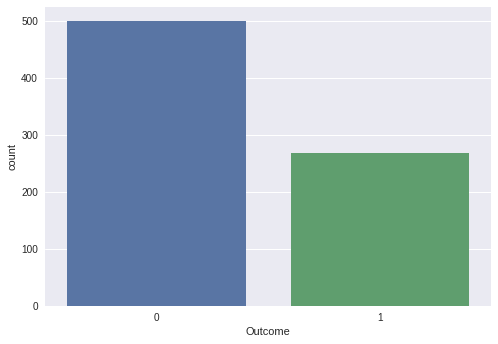

In [0]:
import seaborn as sns
sns.countplot(diabetes['Outcome'], label = "Count")

We wish to train a logistic regression model based on a subset of the data set. Scikit-learn has a function to split a data set into a training and test set.

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(diabetes.loc[:, diabetes.columns != 'Outcome'], 
                                                    diabetes['Outcome'],
                                                    stratify = diabetes['Outcome'],
                                                    random_state = 66)

We can inspect the input features $X$ in the training data set. They have already been shuffled, as indicated by the index of each entry.

In [0]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
612,7,168,88,42,321,38.2,0.787,40
557,8,110,76,0,0,27.8,0.237,58
26,7,147,76,0,0,39.4,0.257,43
70,2,100,66,20,90,32.9,0.867,28
73,4,129,86,20,270,35.1,0.231,23


Now, let's train the logistic regression model and look at the coefficients. This regression will use the cross entropy loss as loss function.

In [0]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train, y_train)
print('Coefficients: \n', logreg.coef_)

Coefficients: 
 [[ 1.08036613e-01  2.74327800e-02 -1.49806403e-02 -1.36737211e-03
  -3.50136849e-04  5.91861497e-02  6.17545218e-01 -9.69377626e-04]]


We can apply the trained model to new input data.

In [0]:
import numpy as np

print(X_test.iloc[0,:])
print(X_test.iloc[0,:].tolist())

row = X_test.iloc[0,:].tolist()
row = np.reshape(row, (1,-1))

print("prediction: ", logreg.predict_proba(row))
print("actual: ", y_test.iloc[0])

Pregnancies                   0.000
Glucose                     180.000
BloodPressure                90.000
SkinThickness                26.000
Insulin                      90.000
BMI                          36.500
DiabetesPedigreeFunction      0.314
Age                          35.000
Name: 506, dtype: float64
[0.0, 180.0, 90.0, 26.0, 90.0, 36.5, 0.314, 35.0]
prediction:  [[0.41020053 0.58979947]]
actual:  1


In [0]:
# Test score is the mean error rate
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 0.781
Test set score: 0.771


In [0]:
logreg001 = LogisticRegression(C=0.01).fit(X_train, y_train)
print('Coefficients: \n', logreg.coef_)
print("Training set accuracy: {:.3f}".format(logreg001.score(X_train, y_train)))
print("Test set accuracy: {:.3f}".format(logreg001.score(X_test, y_test)))

Coefficients: 
 [[ 1.08036613e-01  2.74327800e-02 -1.49806403e-02 -1.36737211e-03
  -3.50136849e-04  5.91861497e-02  6.17545218e-01 -9.69377626e-04]]
Training set accuracy: 0.700
Test set accuracy: 0.703


In [0]:
logreg100 = LogisticRegression(C=100).fit(X_train, y_train)
print('Coefficients: \n', logreg.coef_)
print("Training set accuracy: {:.3f}".format(logreg100.score(X_train, y_train)))
print("Test set accuracy: {:.3f}".format(logreg100.score(X_test, y_test)))

Coefficients: 
 [[ 1.08036613e-01  2.74327800e-02 -1.49806403e-02 -1.36737211e-03
  -3.50136849e-04  5.91861497e-02  6.17545218e-01 -9.69377626e-04]]
Training set accuracy: 0.785
Test set accuracy: 0.766


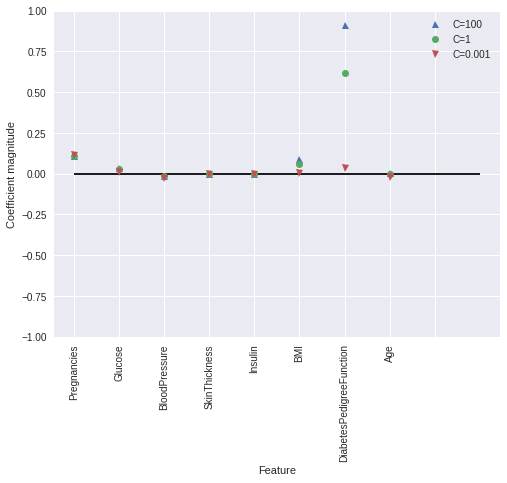

In [0]:
import matplotlib.pyplot as plt

diabetes_features = [x for i,x in enumerate(diabetes.columns) if i!=8]
plt.figure(figsize=(8,6))
plt.plot(logreg100.coef_.T, '^', label="C=100")
plt.plot(logreg.coef_.T, 'o', label="C=1")
plt.plot(logreg001.coef_.T, 'v', label="C=0.001")
plt.xticks(range(diabetes.shape[1]), diabetes_features, rotation=90)
plt.hlines(0, 0, diabetes.shape[1])
plt.ylim(-1, 1)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('log_coef')